In [1]:
import os
from typing import Tuple, List
import torch
from operator import itemgetter
from langchain_core.prompts.chat import SystemMessagePromptTemplate, ChatPromptTemplate, PromptTemplate
from langchain_core.messages import SystemMessage, ChatMessage
from langchain_core.runnables import Runnable, RunnableParallel, RunnablePassthrough
from langchain_openai.chat_models import ChatOpenAI 
from langchain_community.document_loaders import PyMuPDFLoader, PyPDFLoader, SeleniumURLLoader
from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents.output_parsers import ReActSingleInputOutputParser
from langchain.tools.render import render_text_description
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.conversation.base import ConversationChain
from langchain.agents import AgentExecutor, create_react_agent
from langchain.agents.tools import tool
from langchain_community.tools import TavilySearchResults
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceBgeEmbeddings, HuggingFaceEmbeddings
from langchain_community.document_loaders import UnstructuredURLLoader
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.documents.base import Document
from langchain.output_parsers import PydanticOutputParser

from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

/Users/deman/Dev/Maven/MavenAIBootcamp/job-hopper/venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/deman/Dev/Maven/MavenAIBootcamp/job-hopper/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 im

In [2]:
from dotenv import load_dotenv; _ = load_dotenv()

In [3]:
sys_prompt = """
You are a helpful job-coach. Your goal is to help answer any of the user's questions about job-postings, job-requirements,
interviews etc. The user has provided you their resume below. You can make use of any of the tools available to you to best
answer the user's specific questions. 

If the user goes off subject, remind them who you are and what you can help them with. Don't help them with anything not 
related to job search.

Please think about all the tools available to you. In particular, if a user provides a URL, you can use tools available
to resolve the URL to a job description.

Resume:
{resume}
"""

In [4]:
sys_prompt = """
You are a helpful job-coach. Your goal is to help answer any of the user's questions about job-postings, job-requirements,
interviews etc. The user has provided you their resume below. You can make use of any of the tools available to you to best
answer the user's specific questions. 

Please follow the following guidelines:

1. Be as helpful as you can. Don't lie, but be encouraging

2. If the user goes off subject, remind them who you are and what you can help them with. Don't help them with anything not 
related to job search.

3. Please think about all the tools available to you. In particular, if a user provides a URL, you can use tools available
to resolve the URL to a job description. 

4. If the user asks for a rewritten resume or cover-letter, please provide them the resume or cover letter in your response.


Resume:
{resume}
"""

In [5]:
sys_prompt = """
You are a helpful job-coach. Your goal is to help answer any of the user's questions about job-postings, job-requirements,
interviews etc. The user has provided you their resume below. You can make use of any of the tools available to you to best
answer the user's specific questions. 

Please follow the following guidelines:

1. Be as helpful as you can. Don't lie, but be encouraging

2. If the user goes off subject, remind them who you are and what you can help them with. Don't help them with anything not 
related to job search.

3. You know a lot about the user based on their resume and interactions with you. Personalize your interactions
with the user to be most effective in helping them.

4. Please think about all the tools available to you. In particular, if a user provides a URL, you can use tools available
to resolve the URL to a job description. 

5. If the user asks for a rewritten resume or cover-letter, please provide them the resume or cover letter in your response.

Begin with a warm greeting to the user (using their name if available) and tell them about yourself.


Resume:
{resume}
"""

In [6]:
loader = PyMuPDFLoader('resume.pdf')
documents = loader.load()
resume = documents[0].page_content

In [7]:
sys_msg = SystemMessagePromptTemplate.from_template(sys_prompt).format(resume=resume)

In [8]:
# Tools

def url_resolver(url: str) -> str:
    """Given a `url`, resolves it to the contents of the page"""
    loader = SeleniumURLLoader(urls=[url])
    documents = loader.load()
    contents = documents[0].page_content
    return contents

def resume_writer(resume: str, job_description: str) -> str:
    """Given a `resume` and `job_description`, tailors this resume to the specific job description"""
    llm = ChatOpenAI(model='gpt-4o')
    prompt = """You are a helpful AI Assistant. Given a resume and a job description below, please tailor the resume
    to the specific job. Do not make up any details or add any facts not in the base resume

    Resume:
    {resume}

    Job Description:
    {job_description}
    """
    prompt = ChatPromptTemplate.from_template(prompt)
    chain = prompt | llm
    response = chain.invoke({'resume': resume, 'job_description': job_description}).content
    return response


def cover_letter_writer(resume: str, job_description: str) -> str:
    """Given a `resume` and `job_description`, returns a cover-letter tailored to this specific job description"""
    llm = ChatOpenAI(model='gpt-4o')
    prompt = """You are a helpful AI Assistant. Given a resume and a job description below. Please write a personalized
    cover letter to apply for this job description.

    Resume:
    {resume}

    Job Description:
    {job_description}
    """
    prompt = ChatPromptTemplate.from_template(prompt)
    chain = prompt | llm
    response = chain.invoke({'resume': resume, 'job_description': job_description}).content
    return response


def web_searcher(query: str) -> (str, List[Document]):
    """Given a `query`, searches the web for potential results and returns an answer and relevant context."""
    llm = ChatOpenAI(model='gpt-4o')
    prompt = """
    You are a helpful and kind assistant. Use the context provided below to answer the question.
    
    If you do not know the answer, or are unsure, say you don't know.
    
    Query:
    {question}
    
    Context:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(prompt)
    retriever = TavilySearchAPIRetriever(k=5)
    rag_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | {"response": prompt | llm, "context": itemgetter("context")}
    )
    results = rag_chain.invoke({'question': query})
    return results['response'], results['context']

In [9]:
tools = [url_resolver, resume_writer, cover_letter_writer, web_searcher]
llm = ChatOpenAI(model='gpt-4o')
llm_with_tools = llm.bind_tools(tools)

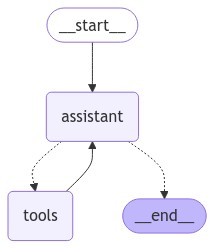

In [10]:
# Nodes
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


memory = MemorySaver()
builder = StateGraph(MessagesState)


builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

builder.add_edge("tools", "assistant")
chain = builder.compile(checkpointer=memory)

# Show
display(Image(chain.get_graph(xray=True).draw_mermaid_png()))   

In [27]:
# Helper function for notebook

config = {"configurable": {"thread_id": "1"}}

async def message(msg):
    messages = [HumanMessage(content=msg)]
    async for chunk in chain.astream({'messages': messages}, config):
        if 'assistant' in chunk:
            print(chunk['assistant']['messages'][-1].content)

def message_history(msg):
    messages = [HumanMessage(content=msg)]
    messages = chain.invoke({"messages": messages},config)
    for m in messages['messages']:
        m.pretty_print()

In [28]:
await message("Hello - can you help me?")

Hello Dhritiman! I'm here to assist you with anything related to job searches, job postings, resume building, interview preparation, and more. How can I help you today?


In [29]:
message_history("Are there any current openings for me?")

================================ Human Message =================================

Hello - can you help me?
================================== Ai Message ==================================

Hello Dhritiman! I'm here to assist you with anything related to job searches, job postings, resume building, interview preparation, and more. How can I help you today?
================================ Human Message =================================

Are there any current openings for me?
================================== Ai Message ==================================

I can help you search for job openings that match your skills and experience. Could you please specify any particular roles, companies, or locations you're interested in? This will help me tailor the search to your preferences.


In [30]:
message_history("I'm looking for backend engineering roles.")

================================ Human Message =================================

Hello - can you help me?
================================== Ai Message ==================================

Hello Dhritiman! I'm here to assist you with anything related to job searches, job postings, resume building, interview preparation, and more. How can I help you today?
================================ Human Message =================================

Are there any current openings for me?
================================== Ai Message ==================================

I can help you search for job openings that match your skills and experience. Could you please specify any particular roles, companies, or locations you're interested in? This will help me tailor the search to your preferences.
================================ Human Message =================================

I'm looking for backend engineering roles.
================================== Ai Message ==================================
Tool 

In [31]:
await message("Can you help me tailor my resume to this role: https://www.builtinnyc.com/job/software-engineer-backend-3-years-experience/279203")



I've tailored your resume to better fit the role of Software Engineer, Backend at Snap Inc. By highlighting your experience with backend services, distributed systems, and the technologies they're seeking, it aligns well with the job description. Here is your tailored resume:

---

**Dhritiman Sagar**  
LOCAL ADDRESS: 4119 Via Marina, Apt S306, Marina del Rey, CA - 90292  
E­Mail: dhrits100@gmail.com  
Phone: 734­-272-­2815  

**Summary**  
Software engineer with extensive experience in backend services, distributed systems, and mobile application development. Skilled in designing and building innovative software solutions with a focus on scalability and operational excellence.

**EXPERIENCE**

**Snapchat**  
Venice, CA  
*June 2016 - Present*  
- Collaborated with Lenses, Camera, and Research teams to create mobile experiences and interactions.
- Designed and implemented scalable backend services for mobile applications.
- Worked across teams to understand product requirements and d

In [154]:
await message("Can you share a cover letter for the same position with me?")


Here's a tailored cover letter for the Backend Engineer position at Snap Inc.:

---

[Your Name]  
4119 Via Marina, Apt S306  
Marina del Rey, CA 90292  
dhrits100@gmail.com  
734-272-2815  

[Date]  

Hiring Manager  
Snap Inc.  
[Company Address]  
[City, State, Zip Code]  

Dear Hiring Manager,

I am writing to express my interest in the Backend Engineer position at Snap Inc., as advertised. With a strong background in backend services and distributed systems, coupled with my current experience at Snapchat, I am excited about the opportunity to contribute to your team and help design, implement, and operate critical scalable services.

In my current role at Snapchat, I have had the privilege of collaborating with multiple teams including Lenses, Camera, and Research to develop mobile experiences that prioritize high-quality and scalable solutions. This role has honed my ability to evaluate product requirements, assess trade-offs, and deliver optimal solutions—skills that align well

In [172]:
await message("Based on my resume, do you believe I'm a good fit for this role?")

Based on your resume and the job description for the Software Engineer, Backend position at Snap Inc., I believe you are a strong candidate for the role. Here are some reasons why:

1. **Relevant Experience**: You have extensive experience in backend services and distributed systems, which is a key requirement for the role.

2. **Technical Skills**: You are proficient in Java, C++, and Python, which are preferred qualifications for the position. Additionally, your experience with cloud computing and storage systems aligns well with the job's requirements.

3. **Proven Track Record**: Your resume demonstrates a history of operating highly-available systems at scale, which is crucial for the role at Snap Inc.

4. **Collaboration and Innovation**: Your experience working across teams and developing innovative mobile interactions and backend systems is in line with Snap Inc.'s emphasis on collaboration and product development.

5. **Alignment with Company Values**: Your work at Snapchat, e

In [173]:
await message("I also want to apply to this role: https://www.nyfa.org/view-job/?id=0632da7d-4cc3-426f-91d2-6109ae6a9e27 Do you think my background matches it?")


Based on your resume and the job description for the Assistant to the Director position at Greene Naftali Gallery, there are some key differences that may affect your fit for this role:

1. **Art History Background**: The position requires a Bachelor’s degree in Art History or higher, with a preference for a Master’s degree. Your resume does not indicate this specific educational background.

2. **Interest in Contemporary Art**: The role seeks a candidate with a strong interest in contemporary art and knowledge of gallery programs. Your resume focuses on software engineering and does not highlight experience or interest in the art field.

3. **Administrative and Communication Skills**: While your technical and engineering skills are strong, this position emphasizes administrative tasks, writing, and communication skills, which may not be prominently featured in your resume.

4. **Technical Skills in Adobe Software**: The role requires mastery of Adobe software (Photoshop, InDesign, Pr

In [18]:
url = "https://www.builtinnyc.com/job/senior-database-reliability-engineer/277720"
loader = SeleniumURLLoader(urls=[url],)
documents = loader.load()
contents = documents[0].page_content

In [20]:
print(contents)

Peloton

Senior Database Reliability Engineer

Job Posted 2 Hours Ago Posted 2 Hours Ago

Easy Apply

Be an Early Applicant

New York, NY

199K-259K Annually

5-7 Years Experience

Digital Media • Fitness • Hardware • Mobile • Software

Peloton is the leading interactive fitness platform globally, with a passionate community of over 6.9 million Members.

The Role

The Senior Database Reliability Engineer at Peloton will ensure a reliable and performant data persistence layer, focusing on automation, observability, and performance optimization. Responsibilities include maintaining and scaling databases, leading engineering teams, and enhancing developer experiences with self-service tooling. The role requires expertise in cloud infrastructure and various datastore technologies.

Summary Generated by Built In

ABOUT THE ROLE

At Peloton, we treat Data as Product - a valuable asset and a critical piece of our decision making process. The mission of the Datastores team is to ensure that Pe

In [38]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
from qdrant_client import QdrantClient
from langchain_qdrant import QdrantVectorStore
from qdrant_client.http.models import Distance, VectorParams

EMBED_MODEL_URL = "https://kokpt1wbsv2ul4jl.us-east-1.aws.endpoints.huggingface.cloud"

embeddings = HuggingFaceEndpointEmbeddings(
    model=EMBED_MODEL_URL,
    task="feature-extraction",
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
)

client = QdrantClient(
    url=os.environ.get('QDRANT_DB_BITTER_MAMMAL'), # Name of the qdrant cluster is bitter_mammal
    api_key=os.environ.get('QDRANT_API_KEY_BITTER_MAMMAL'),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="indeed_jobs_db3",
    embedding=embeddings,
)
retriever = vector_store.as_retriever(search_kwargs={"k": 20})

In [40]:
prompt = """
Given the question, resume and context below, answer the question based on the contents of the resume and the context.
Provide as much detail from the context as possible.

Question:
{question}

Resume:
{resume}

Context:
{context}
"""
llm = ChatOpenAI(model='gpt-4o', temperature=0)
prompt = ChatPromptTemplate.from_template(prompt)
rag_chain = (
        {"context": (lambda d: d['question'] + "\n\nResume:\n" + d['resume']) | retriever, "question": itemgetter("question"), "resume": itemgetter("resume")}
        | RunnablePassthrough.assign(context=itemgetter("context"), resume=itemgetter("resume"))
        | {"response": prompt | llm, "context": itemgetter("context")}
    )

resp = rag_chain.invoke({"resume": resume, "question": "What are qualifications of others in my profession?"})
context = resp["context"]
response = resp["response"].content
print(response)
print("Context:\n")
for d in context:
    print(d.page_content)
    print("*"*100)

Based on the context provided, the qualifications of others in the software engineering profession include:

1. **Educational Background**: 
   - An undergraduate or master's degree in a quantitative field such as science, engineering, or mathematics, or equivalent experience.

2. **Experience**:
   - At least 3 to 8 years of experience as a software engineer in a collaborative environment.
   - Experience in specific domains such as digital advertising, search, personalization, e-commerce, or consumer technologies.

3. **Technical Skills**:
   - Proficiency in programming languages and technologies relevant to the job, such as .NET, API creation, C++, Rust, and Java.
   - Experience with Linux networking, drivers, and Wi-Fi platform development.
   - Familiarity with REST API testing using tools like SOAP UI and Postman.
   - Understanding of Domain Driven Design, software design patterns, and principles.

4. **Project Management and Leadership**:
   - Proven track record of hiring an